In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [22]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf 

# Load labels from the dataset
def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# Defining a helper function for loading a batch of images
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [4]:
#Defining a function to show the stats for batch ans specific sample
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 6:
Image - Min Value: 30 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


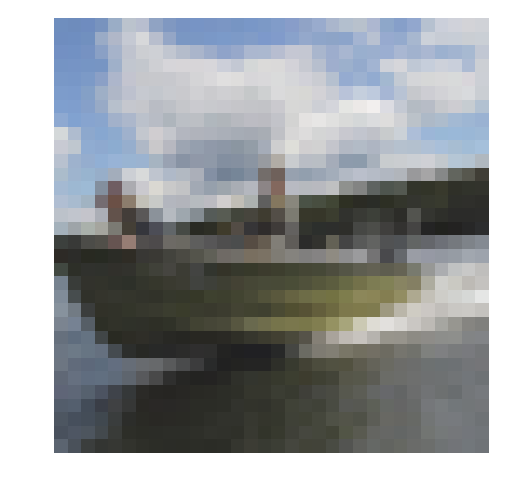

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore a specific batch and sample from the dataset
batch_id = 3
sample_id = 6
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [6]:
#Function used to normalize CIFAR-10 images to be in the range of [0,1]
def normalize(images):        
    # initial zero ndarray    
    normalized_images = np.zeros_like(images.astype(float))        
    
    # The first images index is number of images where the other indices indicates    
    # hieight, width and depth of the image    
    num_images = images.shape[0]        
    
    # Computing the minimum and maximum value of the input image to do the normalization based on them    
    maximum_value, minimum_value = images.max(), images.min()        
    
    # Normalize all the pixel values of the images to be from 0 to 1    
    for img in range(num_images):        
        normalized_images[img,...] = (images[img, ...] - float(minimum_value)) / float(maximum_value - minimum_value)    
    return normalized_images

In [7]:
# encoding the input images. Each image will be represented by a vector of zeros except for the class index of the image 
# that this vector represents. The length of this vector depends on number of classes that we have
# the dataset which is 10 in CIFAR-10

from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(images):        
    num_classes = 10        
    
    #use sklearn helper function of OneHotEncoder() to do that     
    encoder = OneHotEncoder(num_classes)        
    
    #resize the input images to be 2D    
    input_images_resized_to_2d = np.array(images).reshape(-1,1)    
    one_hot_encoded_targets = encoder.fit_transform(input_images_resized_to_2d)
    
    return one_hot_encoded_targets.toarray()

In [8]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

In [9]:

# Call function for preprocessing of the data
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Load the Preprocessed Validation data
valid_input_features, valid_input_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [10]:
# Defining the model inputs
def images_input(img_shape): 
    return tf.placeholder(tf.float32, (None, ) + img_shape, name="input_images")

def target_input(num_classes):  
    target_input = tf.placeholder(tf.int32, (None, num_classes), name="input_images_target") 
    return target_input

#define a function for the dropout layer keep probability
def keep_prob_input(): 
    return tf.placeholder(tf.float32, name="keep_prob")

# Applying a convolution operation to the input tensor followed by max pooling
def conv2d_layer(input_tensor, conv_layer_num_outputs, conv_kernel_size, conv_layer_strides, pool_kernel_size, pool_layer_strides): 
    input_depth = input_tensor.get_shape()[3].value 
    weight_shape = conv_kernel_size + (input_depth, conv_layer_num_outputs,)   
    
    #Defining layer weights and biases 
    weights = tf.Variable(tf.random_normal(weight_shape)) 
    biases = tf.Variable(tf.random_normal((conv_layer_num_outputs,)))  
    
    #Considering the biase variable 
    conv_strides = (1,) + conv_layer_strides + (1,)
    
    conv_layer = tf.nn.conv2d(input_tensor, weights, strides=conv_strides, padding='SAME') 
    conv_layer = tf.nn.bias_add(conv_layer, biases) 
    
    conv_kernel_size = (1,) + conv_kernel_size + (1,) 
    
    pool_strides = (1,) + pool_layer_strides + (1,) 
    pool_layer = tf.nn.max_pool(conv_layer, ksize=conv_kernel_size, strides=pool_strides, padding='SAME') 
    
    return pool_layer

In [11]:
#Flatten the output of max pooling layer to be fing to the fully connected layer which only accepts the output
# to be in 2D
def flatten_layer(input_tensor):
    return tf.contrib.layers.flatten(input_tensor)

#Define the fully connected layer that will use the flattened output of the stacked convolution layers
#to do the actuall classification
def fully_connected_layer(input_tensor, num_outputs): 
    return tf.layers.dense(input_tensor, num_outputs)

#Defining the output function
def output_layer(input_tensor, num_outputs):    
    return  tf.layers.dense(input_tensor, num_outputs)

def build_convolution_net(image_data, keep_prob):  
    # Applying 3 convolution layers followed by max pooling layers 
    conv_layer_1 = conv2d_layer(image_data, 32, (3,3), (1,1), (3,3), (3,3))  
    conv_layer_2 = conv2d_layer(conv_layer_1, 64, (3,3), (1,1), (3,3), (3,3)) 
    conv_layer_3 = conv2d_layer(conv_layer_2, 128, (3,3), (1,1), (3,3), (3,3))
    
    # Flatten the output from 4D to 2D to be fed to the fully connected layer 
    flatten_output = flatten_layer(conv_layer_3)
    
    # Applying 2 fully connected layers with drop out 
    fully_connected_layer_1 = fully_connected_layer(flatten_output, 64) 
    fully_connected_layer_1 = tf.nn.dropout(fully_connected_layer_1, keep_prob) 
    fully_connected_layer_2 = fully_connected_layer(fully_connected_layer_1, 32) 
    fully_connected_layer_2 = tf.nn.dropout(fully_connected_layer_2, keep_prob)  
    
    #Applying the output layer while the output size will be the number of categories that we have 
    #in CIFAR-10 dataset 
    output_logits = output_layer(fully_connected_layer_2, 10)
    
    #returning output 
    return output_logits

In [12]:
def test_conv_net(conv_net):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = conv_net(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print('Neural Network Built!')

In [13]:
#Using the helper function above to build the network
#First off, let's remove all the previous inputs, weights, biases form the previous runs
import tensorflow as tf
tf.reset_default_graph()

# Defining the input placeholders to the convolution neural network
input_images = images_input((32, 32, 3))
input_images_target = target_input(10)
keep_prob = keep_prob_input()

# Building the models
logits_values = build_convolution_net(input_images, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits_values = tf.identity(logits_values, name='logits')

# defining the model loss
model_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_values, labels=input_images_target))

# Defining the model optimizer
model_optimizer = tf.train.AdamOptimizer().minimize(model_cost)

# Calculating and averaging the model accuracy
correct_prediction = tf.equal(tf.argmax(logits_values, 1), tf.argmax(input_images_target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='model_accuracy')

C:\Users\DELL\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [14]:
test_conv_net(build_convolution_net)

Neural Network Built!


In [15]:
#Define a helper function for kicking off the training process
def train(session, model_optimizer, keep_probability, in_feature_batch, target_batch):
    session.run(model_optimizer, feed_dict={input_images: in_feature_batch, input_images_target: target_batch, keep_prob: keep_probability})

#Defining a helper funcitno for print information about the model accuracy and it's validation accuracy as well
def print_model_stats(session, input_feature_batch, target_label_batch, model_cost, model_accuracy):        
    validation_loss = session.run(model_cost, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})    
    validation_accuracy = session.run(model_accuracy, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})        
    
    print("Valid Loss: %f" %(validation_loss))    
    print("Valid accuracy: %f" % (validation_accuracy))

In [16]:
# Model Hyperparameters
num_epochs = 100
batch_size = 128
keep_probability = 0.5

In [17]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [24]:
print('Training on only a Single Batch from the CIFAR-10 Dataset...')
with tf.Session() as sess:  
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    # Training cycle 
    for epoch in range(num_epochs): 
        batch_ind = 1  
        for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
            train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
            
            print('Epoch number {:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
            print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)

Training on only a Single Batch from the CIFAR-10 Dataset...
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1040.045776
Valid accuracy: 0.140625
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1230.743286
Valid accuracy: 0.117188
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1342.931885
Valid accuracy: 0.156250
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1165.671997
Valid accuracy: 0.132812
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 717.791260
Valid accuracy: 0.093750
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 873.454834
Valid accuracy: 0.085938
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 835.065918
Valid accuracy: 0.148438
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 854.956604
Valid accuracy: 0.109375
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 759.506042
Valid accuracy: 0.156250
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 864.311584
Valid accuracy: 0.109375
Epoch number  1, CIFAR-10 Batch Num

Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 189.720306
Valid accuracy: 0.320312
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 205.383530
Valid accuracy: 0.265625
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 215.269028
Valid accuracy: 0.195312
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 186.933563
Valid accuracy: 0.351562
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 232.290283
Valid accuracy: 0.242188
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 218.911514
Valid accuracy: 0.312500
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 217.955505
Valid accuracy: 0.296875
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 206.422287
Valid accuracy: 0.273438
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 213.073685
Valid accuracy: 0.312500
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 225.049713
Valid accuracy: 0.296875
Epoch number  2, CIFAR-10 Batch Number 1: Valid Loss: 161.742004
Valid accuracy: 0.390625
Epoch numb

Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 139.138641
Valid accuracy: 0.296875
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 155.231354
Valid accuracy: 0.304688
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 152.744934
Valid accuracy: 0.328125
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 138.070465
Valid accuracy: 0.335938
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 111.564804
Valid accuracy: 0.445312
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 113.266502
Valid accuracy: 0.312500
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 118.083397
Valid accuracy: 0.367188
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 110.023537
Valid accuracy: 0.320312
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 136.717865
Valid accuracy: 0.281250
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 99.873627
Valid accuracy: 0.343750
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 90.732330
Valid accuracy: 0.445312
Epoch number

Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 97.499435
Valid accuracy: 0.250000
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 99.468628
Valid accuracy: 0.398438
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 92.743332
Valid accuracy: 0.343750
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 79.007965
Valid accuracy: 0.328125
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 67.192841
Valid accuracy: 0.421875
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 70.364410
Valid accuracy: 0.390625
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 66.285324
Valid accuracy: 0.398438
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 73.012772
Valid accuracy: 0.375000
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 64.259987
Valid accuracy: 0.429688
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 75.623474
Valid accuracy: 0.351562
Epoch number  4, CIFAR-10 Batch Number 1: Valid Loss: 92.042702
Valid accuracy: 0.312500
Epoch number  4, CIFA

Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 52.933491
Valid accuracy: 0.453125
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 56.148205
Valid accuracy: 0.328125
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 60.918591
Valid accuracy: 0.367188
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 46.721710
Valid accuracy: 0.375000
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 51.541641
Valid accuracy: 0.382812
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 50.865944
Valid accuracy: 0.398438
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 60.367043
Valid accuracy: 0.328125
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 52.890362
Valid accuracy: 0.453125
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 48.734428
Valid accuracy: 0.375000
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 47.959969
Valid accuracy: 0.484375
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 47.014442
Valid accuracy: 0.421875
Epoch number  6, CIFA

Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 41.383514
Valid accuracy: 0.328125
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 33.497200
Valid accuracy: 0.414062
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 27.997486
Valid accuracy: 0.468750
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 36.906876
Valid accuracy: 0.406250
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 33.731945
Valid accuracy: 0.460938
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 42.760056
Valid accuracy: 0.398438
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 33.892952
Valid accuracy: 0.476562
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 45.012775
Valid accuracy: 0.414062
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 36.737907
Valid accuracy: 0.390625
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 36.998543
Valid accuracy: 0.375000
Epoch number  7, CIFAR-10 Batch Number 1: Valid Loss: 42.384747
Valid accuracy: 0.398438
Epoch number  7, CIFA

Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 24.993469
Valid accuracy: 0.429688
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 26.900066
Valid accuracy: 0.429688
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 33.390739
Valid accuracy: 0.359375
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 24.959942
Valid accuracy: 0.507812
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 27.247406
Valid accuracy: 0.437500
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 25.545662
Valid accuracy: 0.484375
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 24.552917
Valid accuracy: 0.398438
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 23.000067
Valid accuracy: 0.453125
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 32.729416
Valid accuracy: 0.328125
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 29.238041
Valid accuracy: 0.406250
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 27.760342
Valid accuracy: 0.437500
Epoch number  8, CIFA

Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 18.532116
Valid accuracy: 0.445312
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 19.767109
Valid accuracy: 0.421875
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 21.132015
Valid accuracy: 0.437500
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 18.522324
Valid accuracy: 0.507812
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 23.518707
Valid accuracy: 0.390625
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 23.604534
Valid accuracy: 0.359375
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 15.785524
Valid accuracy: 0.476562
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 18.995325
Valid accuracy: 0.500000
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 20.859497
Valid accuracy: 0.460938
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 18.430988
Valid accuracy: 0.398438
Epoch number 10, CIFAR-10 Batch Number 1: Valid Loss: 21.576410
Valid accuracy: 0.398438
Epoch number 10, CIFA

Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 14.940376
Valid accuracy: 0.437500
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 18.969774
Valid accuracy: 0.460938
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 18.856169
Valid accuracy: 0.484375
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 17.448334
Valid accuracy: 0.406250
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 17.807796
Valid accuracy: 0.367188
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 16.860907
Valid accuracy: 0.390625
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 18.298187
Valid accuracy: 0.437500
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 13.037252
Valid accuracy: 0.476562
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 20.273256
Valid accuracy: 0.375000
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 13.935870
Valid accuracy: 0.492188
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 12.067232
Valid accuracy: 0.429688
Epoch number 11, CIFA

Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 8.682035
Valid accuracy: 0.484375
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 11.434224
Valid accuracy: 0.468750
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 11.953505
Valid accuracy: 0.453125
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 11.823744
Valid accuracy: 0.445312
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 12.692997
Valid accuracy: 0.406250
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 11.986578
Valid accuracy: 0.445312
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 9.338953
Valid accuracy: 0.593750
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 11.542062
Valid accuracy: 0.507812
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 10.340532
Valid accuracy: 0.445312
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 12.335385
Valid accuracy: 0.500000
Epoch number 12, CIFAR-10 Batch Number 1: Valid Loss: 13.822418
Valid accuracy: 0.429688
Epoch number 12, CIFAR-

Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 8.142044
Valid accuracy: 0.523438
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 8.702639
Valid accuracy: 0.429688
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 10.862726
Valid accuracy: 0.468750
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 9.261562
Valid accuracy: 0.445312
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 8.779174
Valid accuracy: 0.437500
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 11.462677
Valid accuracy: 0.406250
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 9.418479
Valid accuracy: 0.400000
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 9.179050
Valid accuracy: 0.476562
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 7.207890
Valid accuracy: 0.468750
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 8.562090
Valid accuracy: 0.468750
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 10.325618
Valid accuracy: 0.414062
Epoch number 14, CIFAR-10 Bat

Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 9.636460
Valid accuracy: 0.421875
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 6.533441
Valid accuracy: 0.492188
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 6.524216
Valid accuracy: 0.437500
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 6.170601
Valid accuracy: 0.546875
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 6.003599
Valid accuracy: 0.484375
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 7.369221
Valid accuracy: 0.437500
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 6.116007
Valid accuracy: 0.421875
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 5.921601
Valid accuracy: 0.453125
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 7.732614
Valid accuracy: 0.468750
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 8.334022
Valid accuracy: 0.468750
Epoch number 15, CIFAR-10 Batch Number 1: Valid Loss: 6.805125
Valid accuracy: 0.484375
Epoch number 15, CIFAR-10 Batch 

Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 7.235070
Valid accuracy: 0.437500
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.251638
Valid accuracy: 0.382812
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 4.973821
Valid accuracy: 0.375000
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.470548
Valid accuracy: 0.468750
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.476855
Valid accuracy: 0.484375
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.989302
Valid accuracy: 0.453125
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 4.080525
Valid accuracy: 0.500000
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.087090
Valid accuracy: 0.445312
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.301561
Valid accuracy: 0.460938
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 4.774460
Valid accuracy: 0.453125
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.186870
Valid accuracy: 0.398438
Epoch number 16, CIFAR-10 Batch 

Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 5.443758
Valid accuracy: 0.375000
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 3.696133
Valid accuracy: 0.429688
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 4.001776
Valid accuracy: 0.484375
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 4.039444
Valid accuracy: 0.445312
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 3.637572
Valid accuracy: 0.515625
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 3.388884
Valid accuracy: 0.460938
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 3.520041
Valid accuracy: 0.445312
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 4.049810
Valid accuracy: 0.429688
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 3.376219
Valid accuracy: 0.437500
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 3.524200
Valid accuracy: 0.398438
Epoch number 17, CIFAR-10 Batch Number 1: Valid Loss: 4.715728
Valid accuracy: 0.406250
Epoch number 17, CIFAR-10 Batch 

Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.993952
Valid accuracy: 0.382812
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 3.376902
Valid accuracy: 0.375000
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.858319
Valid accuracy: 0.390625
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 3.166138
Valid accuracy: 0.445312
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.863998
Valid accuracy: 0.382812
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 4.405281
Valid accuracy: 0.375000
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.765990
Valid accuracy: 0.421875
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 3.066142
Valid accuracy: 0.492188
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 3.159380
Valid accuracy: 0.375000
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.703147
Valid accuracy: 0.398438
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 3.595251
Valid accuracy: 0.406250
Epoch number 19, CIFAR-10 Batch 

Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 2.209413
Valid accuracy: 0.382812
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 2.843789
Valid accuracy: 0.367188
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 2.466116
Valid accuracy: 0.390625
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 2.852192
Valid accuracy: 0.382812
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 2.490684
Valid accuracy: 0.453125
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 3.411460
Valid accuracy: 0.382812
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 2.328797
Valid accuracy: 0.351562
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 2.351226
Valid accuracy: 0.359375
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 2.412679
Valid accuracy: 0.390625
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 2.600442
Valid accuracy: 0.468750
Epoch number 20, CIFAR-10 Batch Number 1: Valid Loss: 2.638649
Valid accuracy: 0.406250
Epoch number 20, CIFAR-10 Batch 

Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.174891
Valid accuracy: 0.429688
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.099883
Valid accuracy: 0.320312
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.897915
Valid accuracy: 0.398438
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.247680
Valid accuracy: 0.343750
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.221123
Valid accuracy: 0.437500
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.566197
Valid accuracy: 0.359375
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.785136
Valid accuracy: 0.406250
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.025217
Valid accuracy: 0.453125
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.235628
Valid accuracy: 0.500000
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.113472
Valid accuracy: 0.437500
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 2.028738
Valid accuracy: 0.406250
Epoch number 21, CIFAR-10 Batch 

Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.838753
Valid accuracy: 0.359375
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 2.019680
Valid accuracy: 0.281250
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.598258
Valid accuracy: 0.421875
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.592399
Valid accuracy: 0.445312
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.802442
Valid accuracy: 0.328125
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.659196
Valid accuracy: 0.351562
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.931356
Valid accuracy: 0.367188
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.842912
Valid accuracy: 0.312500
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.842709
Valid accuracy: 0.367188
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 1.859072
Valid accuracy: 0.343750
Epoch number 23, CIFAR-10 Batch Number 1: Valid Loss: 2.125144
Valid accuracy: 0.289062
Epoch number 23, CIFAR-10 Batch 

Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.670744
Valid accuracy: 0.343750
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.719630
Valid accuracy: 0.421875
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.528137
Valid accuracy: 0.390625
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.851837
Valid accuracy: 0.343750
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.639333
Valid accuracy: 0.390625
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.747967
Valid accuracy: 0.304688
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.742026
Valid accuracy: 0.351562
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.697551
Valid accuracy: 0.359375
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.752679
Valid accuracy: 0.351562
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.619760
Valid accuracy: 0.406250
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.836882
Valid accuracy: 0.351562
Epoch number 24, CIFAR-10 Batch 

KeyboardInterrupt: 